In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from jupyterthemes import jtplot
jtplot.style(theme='onedork', figsize=(20,10))
plt.style.use('tableau-colorblind10')

In [3]:
df = pd.read_feather('data/train.feather')

In [4]:
OPS = ['mean', 'median', 'std']

def aggregate(data, time_slice, sample=None):
    if sample is not None:
        data = data.sample(sample)
    return (data.groupby(pd.Grouper(key='pickup_datetime', freq=time_slice))
             .fare_amount
             .agg(OPS)
             .rename(columns={col: '-'.join((col, time_slice)) for col in OPS})) 

In [5]:
%%time
SAMPLE = int(1e6)
TIME_SLICES = ['1M', '1W', '1D', '12H', '6H', '3H', '1H']
grouped = {t: aggregate(df, t, SAMPLE) for t in TIME_SLICES}

CPU times: user 29.3 s, sys: 1.82 s, total: 31.1 s
Wall time: 32.9 s


Text(0,0.5,'Price ($)')

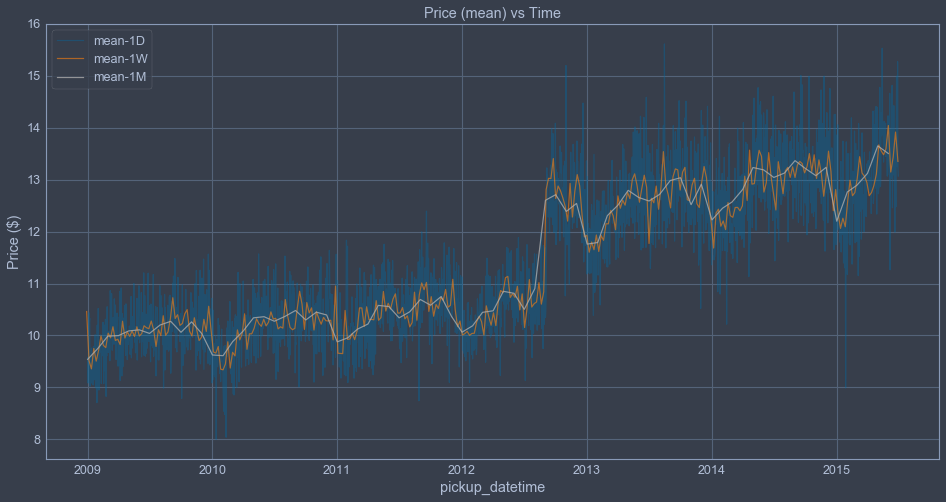

In [6]:
ax = plt.axes()

# skipping hour scale for now
not_hour = set(filter(lambda c: 'H' not in c, TIME_SLICES))
alpha_step = 0.2
alpha = 1 - (len(not_hour) * alpha_step)

for scale, aggs in reversed(list(grouped.items())):
    # skip hour scale for now
    if scale in not_hour:
        cols = [c for c in aggs.columns if 'mean' in c]
        aggs[cols].plot(ax=ax, alpha=alpha)
        # make it more subtle as the scale gets smaller
        alpha += alpha_step
plt.title('Price (mean) vs Time')
plt.ylabel('Price ($)')

In [7]:
df['hour'] = df.pickup_datetime.dt.hour
df['dow'] = df.pickup_datetime.dt.dayofweek
df['month'] = df.pickup_datetime.dt.month
df['year'] = df.pickup_datetime.dt.year
df['day'] = df.pickup_datetime.dt.day

(0, 24)

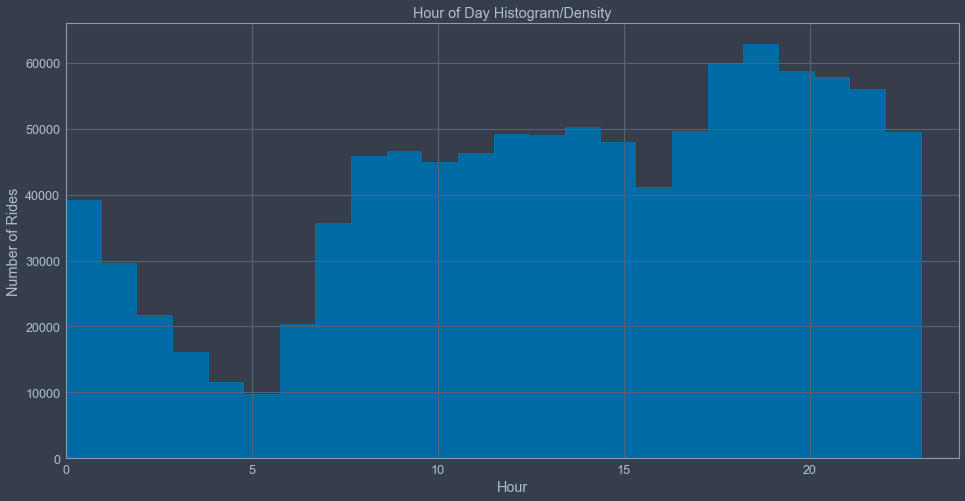

In [8]:
sampled = df.sample(SAMPLE)
sampled.hour.plot.hist(bins=24)
plt.title('Hour of Day Histogram/Density')
plt.xlabel('Hour')
plt.ylabel('Number of Rides')
plt.xlim(0,24)

In [9]:
def plot_by_dt(unit):
    agg = (df.sample(SAMPLE)
       .groupby(unit)
       .fare_amount
       .agg(OPS))

    (agg[['mean']]
        .plot
        .bar(yerr=agg['std']))
    plt.title('Price (mean) vs {} w/Error Bars'.format(unit))
    plt.ylabel('Price ($)')

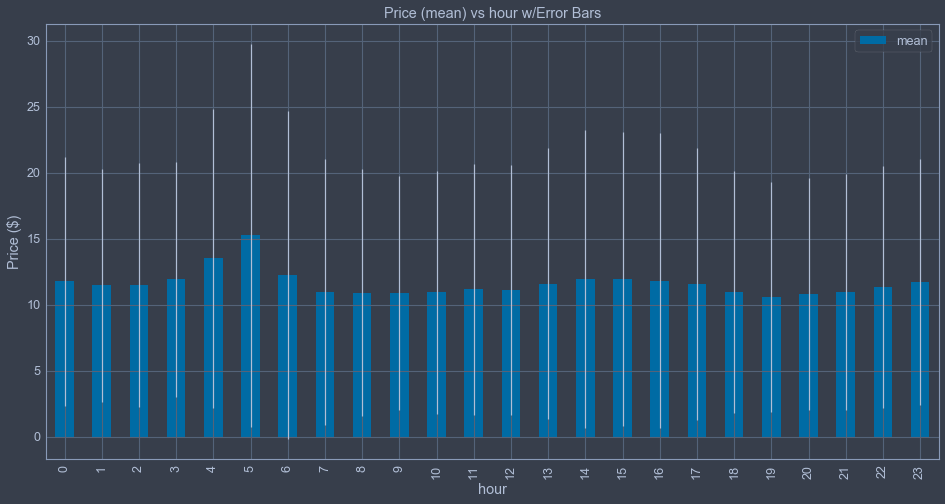

In [10]:
plot_by_dt('hour')

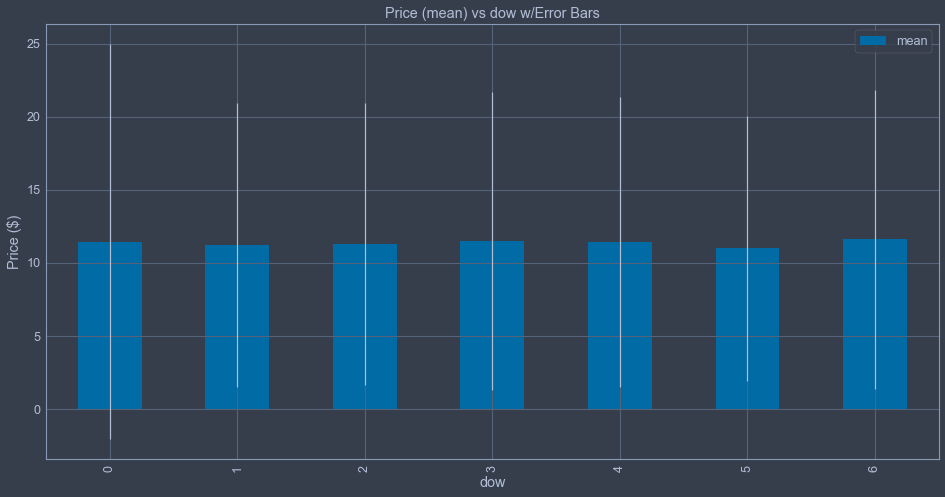

In [11]:
plot_by_dt('dow')

Text(0,0.5,'Price ($)')

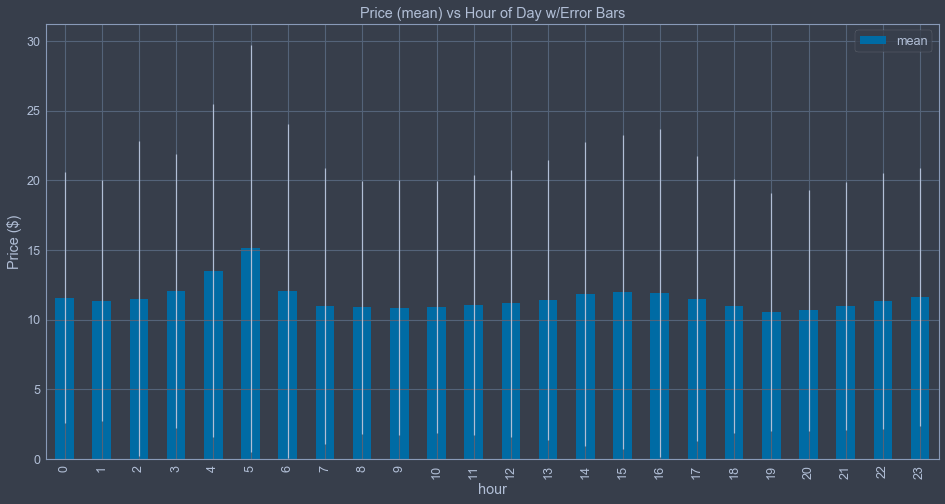

In [12]:
hour = (df.sample(SAMPLE)
       .groupby('hour')
       .fare_amount
       .agg(OPS))

(hour[['mean']]
    .plot
    .bar(yerr=hour['std']))
plt.title('Price (mean) vs Hour of Day w/Error Bars')
plt.ylabel('Price ($)')

In [13]:
def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)

    All args must be of equal length.    
    """
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    return km

In [14]:
def degrees_to_cardinal(d):
    dirs = ["N", "NNE", "NE", "ENE", "E", "ESE", "SE", "SSE",
            "S", "SSW", "SW", "WSW", "W", "WNW", "NW", "NNW"]
    ix = int((d + 11.25)/22.5)
    return dirs[ix % 16]

In [15]:
def calculate_initial_compass_bearing(pointA, pointB):
    """
    Calculates the bearing between two points.
    The formulae used is the following:
        θ = atan2(sin(Δlong).cos(lat2),
                  cos(lat1).sin(lat2) − sin(lat1).cos(lat2).cos(Δlong))
    """
    if (type(pointA) != tuple) or (type(pointB) != tuple):
        raise TypeError("Only tuples are supported as arguments")

    lat1 = np.radians(pointA[0])
    lat2 = np.radians(pointB[0])

    diffLong = np.radians(pointB[1] - pointA[1])

    x = np.sin(diffLong) * np.cos(lat2)
    y = np.cos(lat1) * np.sin(lat2) - (np.sin(lat1)
            * np.cos(lat2) * np.cos(diffLong))

    initial_bearing = np.arctan2(x, y)

    # Now we have the initial bearing but math.atan2 return values
    # from -180° to + 180° which is not what we want for a compass bearing
    # The solution is to normalize the initial bearing as shown below
    initial_bearing = np.degrees(initial_bearing)
    compass_bearing = (initial_bearing + 360) % 360

    return compass_bearing

In [16]:
%%time
df['distance'] = haversine(df.pickup_longitude, df.pickup_latitude, df.dropoff_longitude, df.dropoff_latitude)

CPU times: user 12.6 s, sys: 6.62 s, total: 19.2 s
Wall time: 13.1 s


In [17]:
%%time
df['degrees'] = calculate_initial_compass_bearing((df.pickup_longitude, df.pickup_latitude), (df.dropoff_longitude, df.dropoff_latitude))

CPU times: user 8.48 s, sys: 5.46 s, total: 13.9 s
Wall time: 11 s


In [18]:
# %%time
# df['direction'] = df.degrees.apply(degrees_to_cardinal)

In [19]:
clf = RandomForestRegressor(max_depth=15, max_features=5, n_estimators=500, n_jobs=-1)

In [20]:
data = df.sample(500000).dropna(axis=0, how='any')

In [21]:
y = data.fare_amount.values

In [26]:
features = ['pickup_longitude','pickup_latitude', 'dropoff_longitude',
          'dropoff_latitude', 'passenger_count', 'distance', 'year',
          'month', 'day', 'hour', 'dow', 'degrees']
X = data[features].values

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [24]:
%%time
clf.fit(X_train, y_train)

CPU times: user 16min 15s, sys: 5.64 s, total: 16min 21s
Wall time: 5min 16s


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=15,
           max_features=5, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=500, n_jobs=-1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [25]:
print('RMSE', np.sqrt(mean_squared_error(y_test, clf.predict(X_test))))

RMSE 4.189382598144047


In [41]:
importances = pd.DataFrame.from_records(list(zip(clf.feature_importances_, features))).rename(columns={0: 'score', 1: 'feature'})

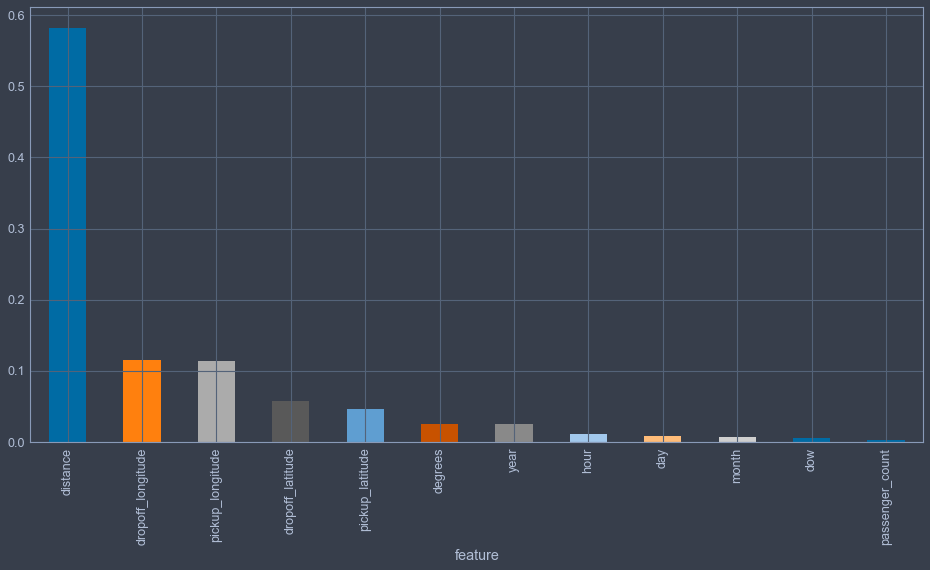

In [42]:
importances.set_index('feature').score.sort_values(ascending=False).plot.bar()